# 12.4. Simulating a partial differential equation — reaction-diffusion systems and Turing patterns

In [14]:
import sys
sys.path.append('../../..')
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
from MyPackage.Models.SelkovStrogatz.SelkovStrogatz1DConfiguration import SelkovStrogatz1DConfiguration

In [16]:
import numpy as np
import pylab as plt
%matplotlib inline

from tqdm import tqdm
from numba import njit
import seaborn as sns
from numba_progress import ProgressBar

In [17]:
a = 0.0275
b = 1.0
D_u = 0.001
D_v = 0.01

In [19]:
d_h = 0.01
d_t = 0.001
coeff_h_t = d_t / d_h / d_h
h_max = 1
t_max = 2000

In [20]:
size = int(round(h_max / d_h))  # size of the 2D grid

iters = int(round(t_max / d_t))  # number of iterations

In [21]:
conf = SelkovStrogatz1DConfiguration(a,b,d_h,d_h)
u_eq, v_eq = conf.get_stale_homogenous_solution()
u_eq, v_eq

(1.0, 0.97323600973236)

In [22]:
@njit(fastmath=True)
def calc_next(U, V, D_u, coeff_h_t, d_t, a, b):
    Utop = U[0:-2, 1:-1]
    Uleft = U[1:-1, 0:-2]
    Ubottom = U[2:, 1:-1]
    Uright = U[1:-1, 2:]
    Ucenter = U[1:-1, 1:-1]
    U_laplacian = (Utop + Uleft + Ubottom + Uright - 4 * Ucenter)

    Vtop = V[0:-2, 1:-1]
    Vleft = V[1:-1, 0:-2]
    Vbottom = V[2:, 1:-1]
    Vright = V[1:-1, 2:]
    Vcenter = V[1:-1, 1:-1]
    V_laplacian = (Vtop + Vleft + Vbottom + Vright - 4 * Vcenter)
    
    U[1:-1, 1:-1], V[1:-1, 1:-1] = \
        Ucenter - d_t * Ucenter + d_t * a * Vcenter + d_t * Ucenter ** 2 * Vcenter + coeff_h_t * D_u * U_laplacian, \
        Vcenter + d_t * b - d_t * a * Vcenter -  d_t * Ucenter ** 2 * Vcenter + coeff_h_t * D_v * V_laplacian

    for Z in (U, V):
        Z[0, :] = Z[1, :]
        Z[-1, :] = Z[-2, :]
        Z[:, 0] = Z[:, 1]
        Z[:, -1] = Z[:, -2]

    return U, V

@njit(fastmath=True)
def calc_n_iters(U, V, D_u, coeff_h_t, d_t, a, b, n_iters, steps_to_save):
    res_u = np.empty((int(n_iters / len(steps_to_save)) + 1, *U.shape),dtype=np.float32)
    res_v = np.empty((int(n_iters / len(steps_to_save)) + 1, *V.shape),dtype=np.float32)
    steps_to_save = sorted(steps_to_save)
    i = 0
    for index in range(n_iters):        
        if index in steps_to_save:
            res_u[i] = U
            res_v[i] = V
            i+=1
        U,V = calc_next(U, V, D_u, coeff_h_t, d_t, a, b)
    res_u[-1] = U
    res_v[-1] = V
    return U, V, res_u, res_v

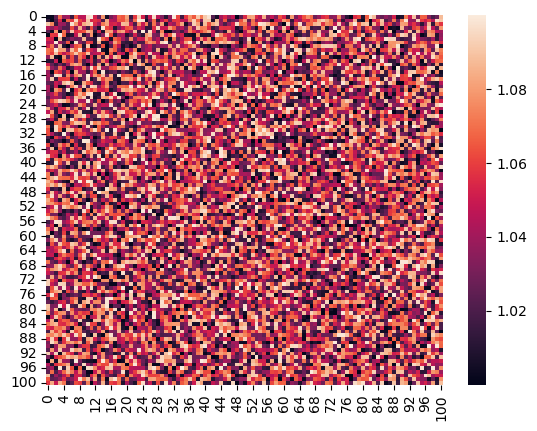

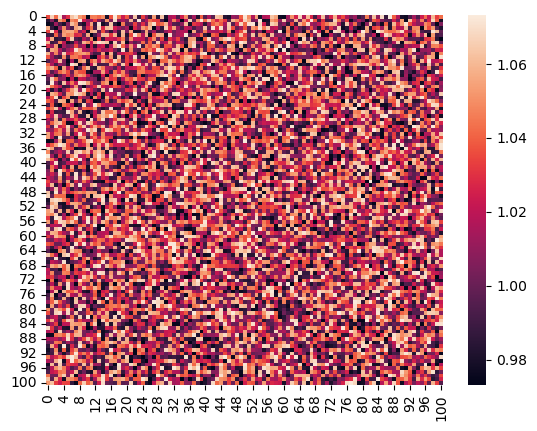

In [23]:
U = np.random.rand(101, 101) * 0.1 + u_eq
V = np.random.rand(101, 101) * 0.1 + v_eq
sns.heatmap(U)
plt.show()
sns.heatmap(V)
plt.show()

In [20]:
import pyarrow.parquet as pq

In [24]:
size

100

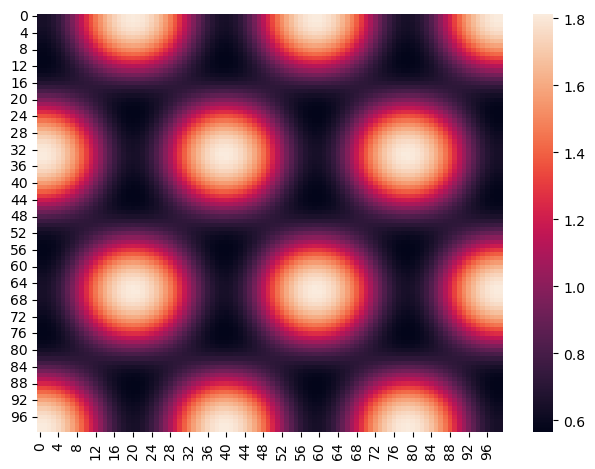

In [25]:
U = np.random.rand(size, size) * 0.1 + u_eq
V = np.random.rand(size, size) * 0.1 + v_eq


U, V, res_u, res_v = calc_n_iters(U, V, D_u, coeff_h_t, d_t, 0.0775, 1.0,5000000, (0,5,100,1000,10000,100000))
ax = sns.heatmap(U)
plt.tight_layout()
plt.show()
    

In [27]:
import pyarrow as pa
import pyarrow.parquet as pq

In [28]:
data = pq.read_table('/media/alexander/BigDisk/data/0.0025_1.0_0/process.parquet', columns=['u', 'v'])

In [34]:
a = data['u'].to_numpy().reshape((-1,201,201))

<AxesSubplot:>

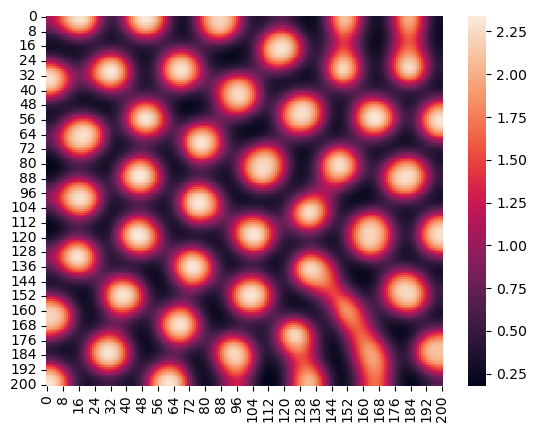

In [37]:
sns.heatmap(a[-1])

In [38]:

table = pa.table([res_u.ravel().round(2), res_v.ravel().round(2)],
                           names=["u", "v"])

In [40]:
pq.write_table(table, 'sas.parquet',)

<AxesSubplot:>

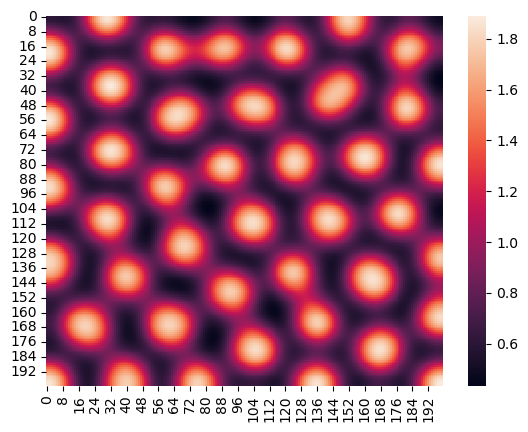

In [56]:
sns.heatmap(res_u[-1])

In [41]:
!du -sh sas.parquet

4,7M	sas.parquet


In [15]:
res_u.shape, res_u.dtype

((102, 200, 200), dtype('float32'))

In [18]:
100 / (102*200*200*4/1024/1024/1024)

6579.3003921568625

100%|██████████| 100/100 [05:01<00:00,  3.02s/it]


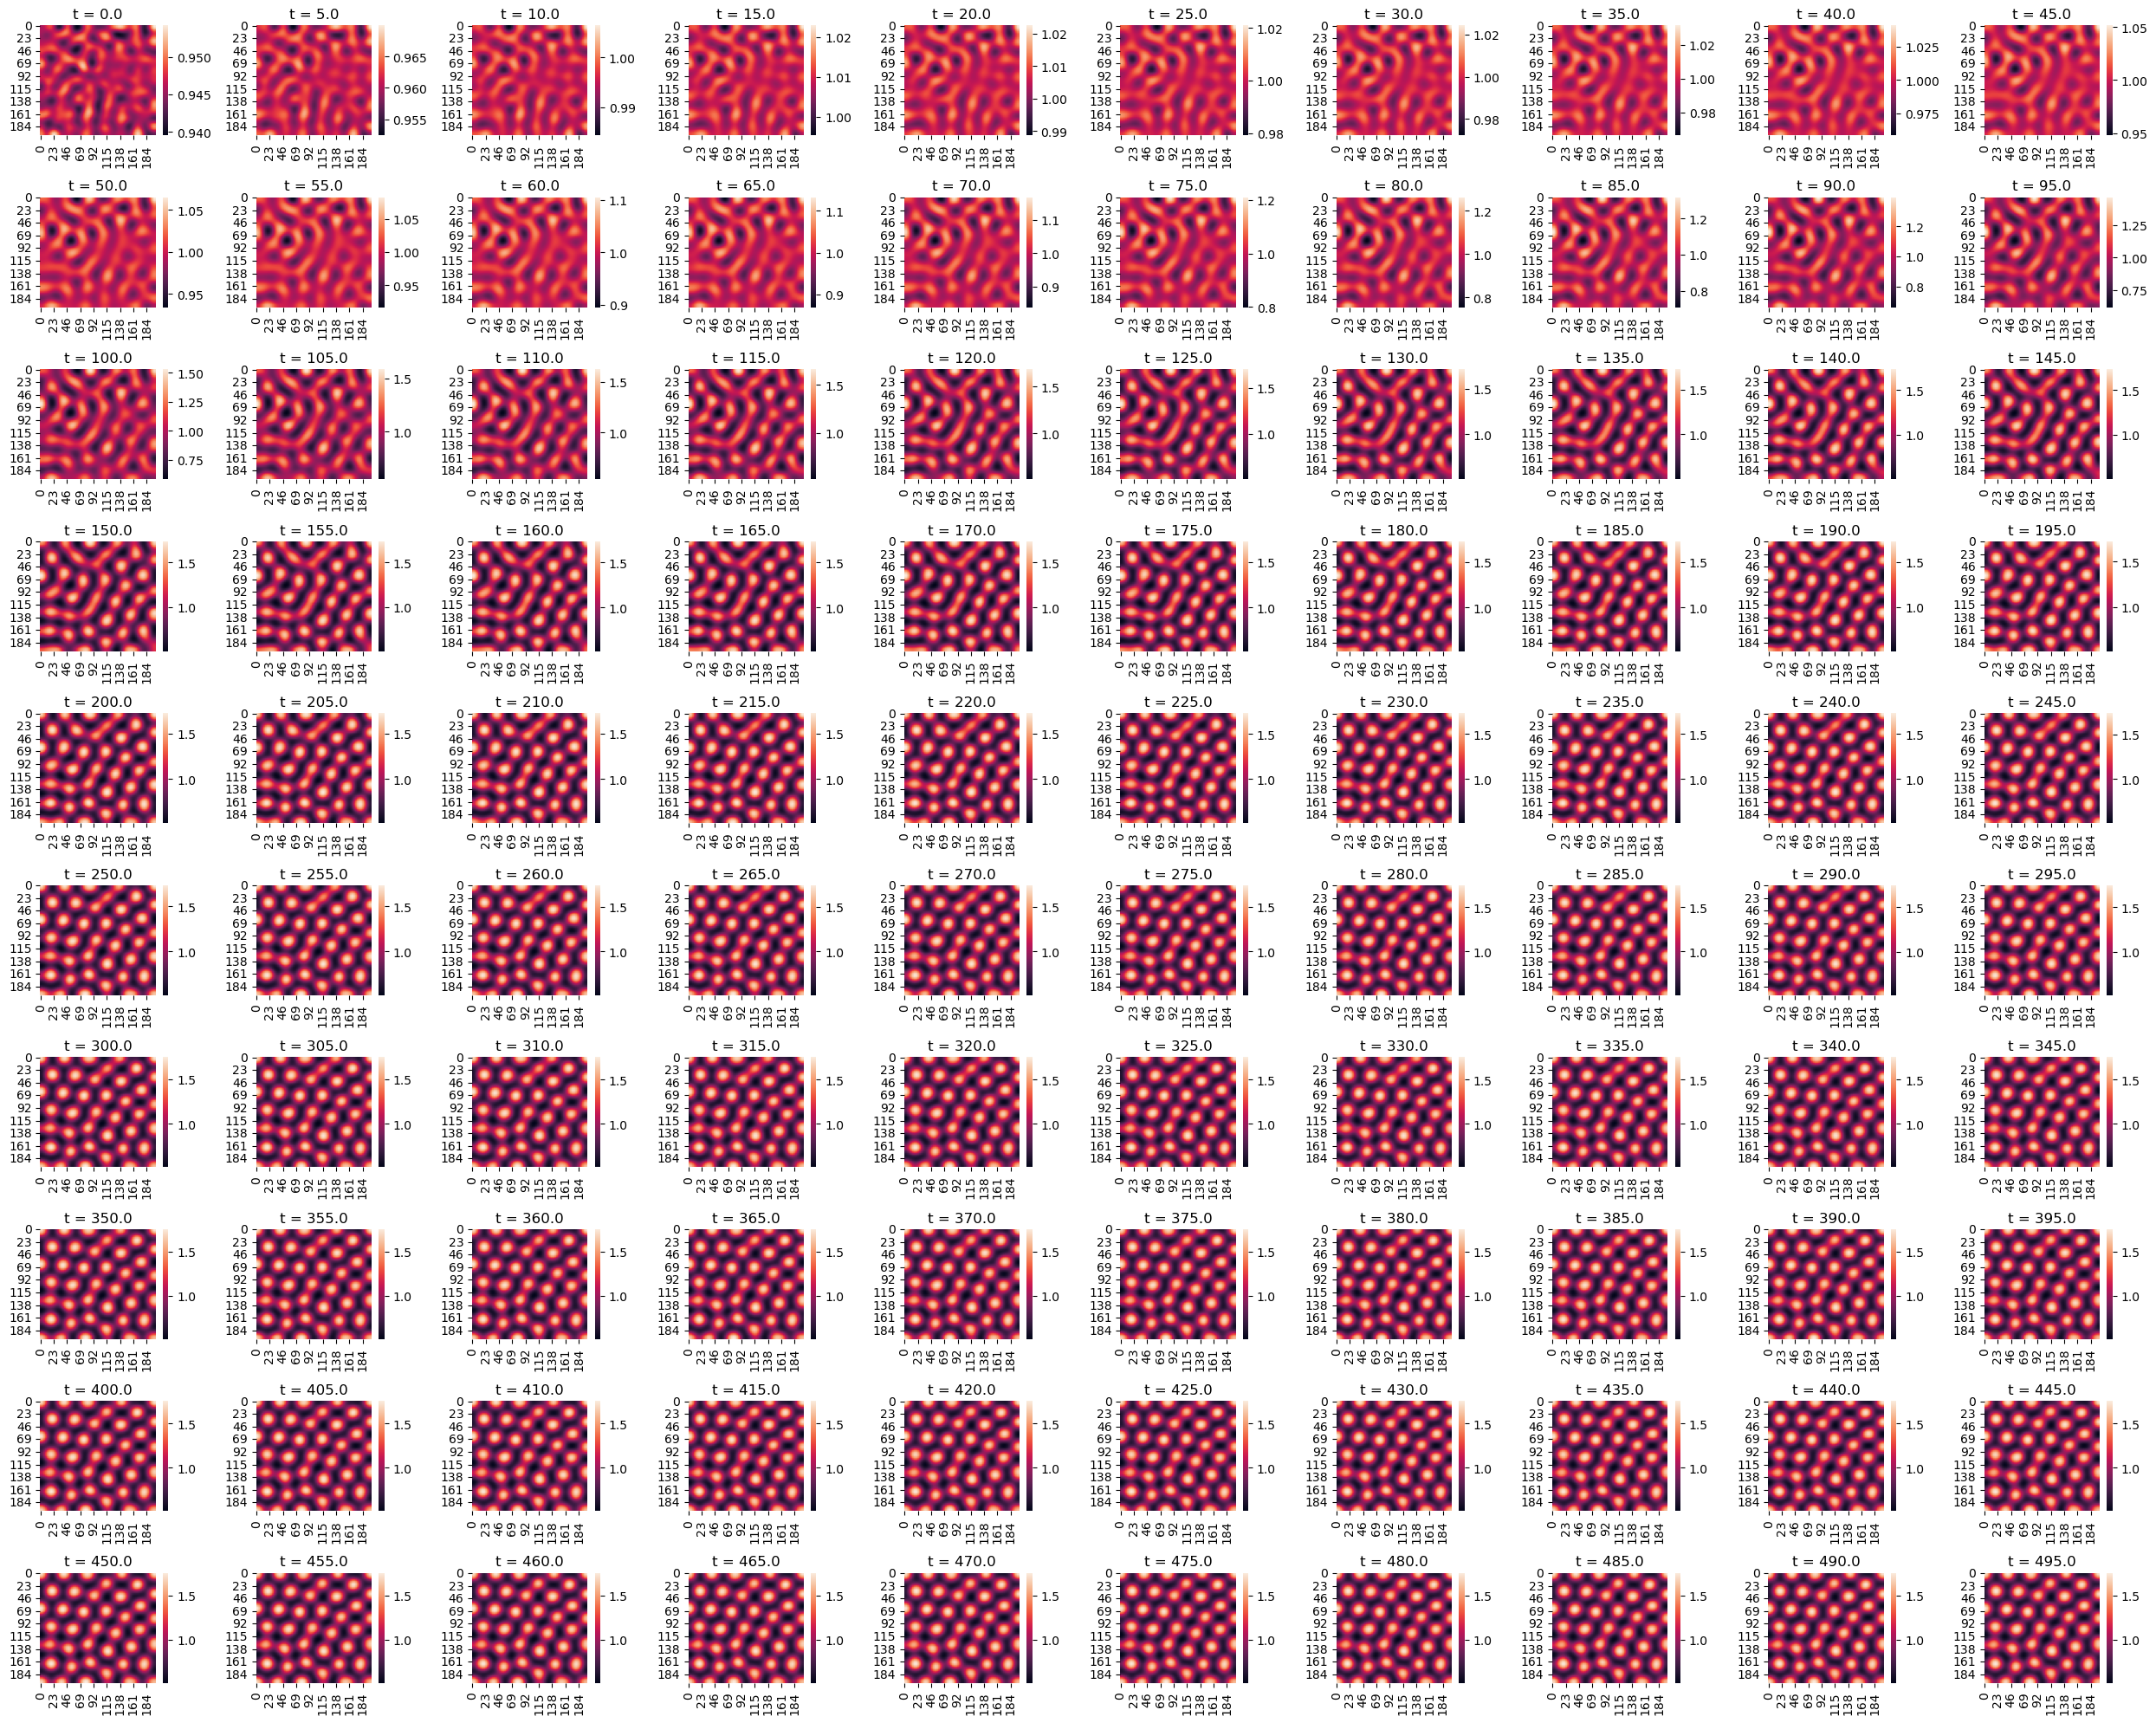

In [27]:
U = np.random.rand(size, size) * 0.1 + u_eq
V = np.random.rand(size, size) * 0.1 + v_eq
fig, axes = ax = plt.subplots(10,10, figsize=(25,20))
axes = axes.flatten()
for chunk_num in tqdm(range(100)):
    U,V = calc_n_iters(U, V, D_u, coeff_h_t, d_t, 0.09, 1.0, 5000)
    ax = sns.heatmap(U, ax = axes[chunk_num])
    ax.set_title(f't = {chunk_num * 5000 * d_t}')
plt.tight_layout()
plt.show()
    

100%|██████████| 100/100 [05:01<00:00,  3.01s/it]


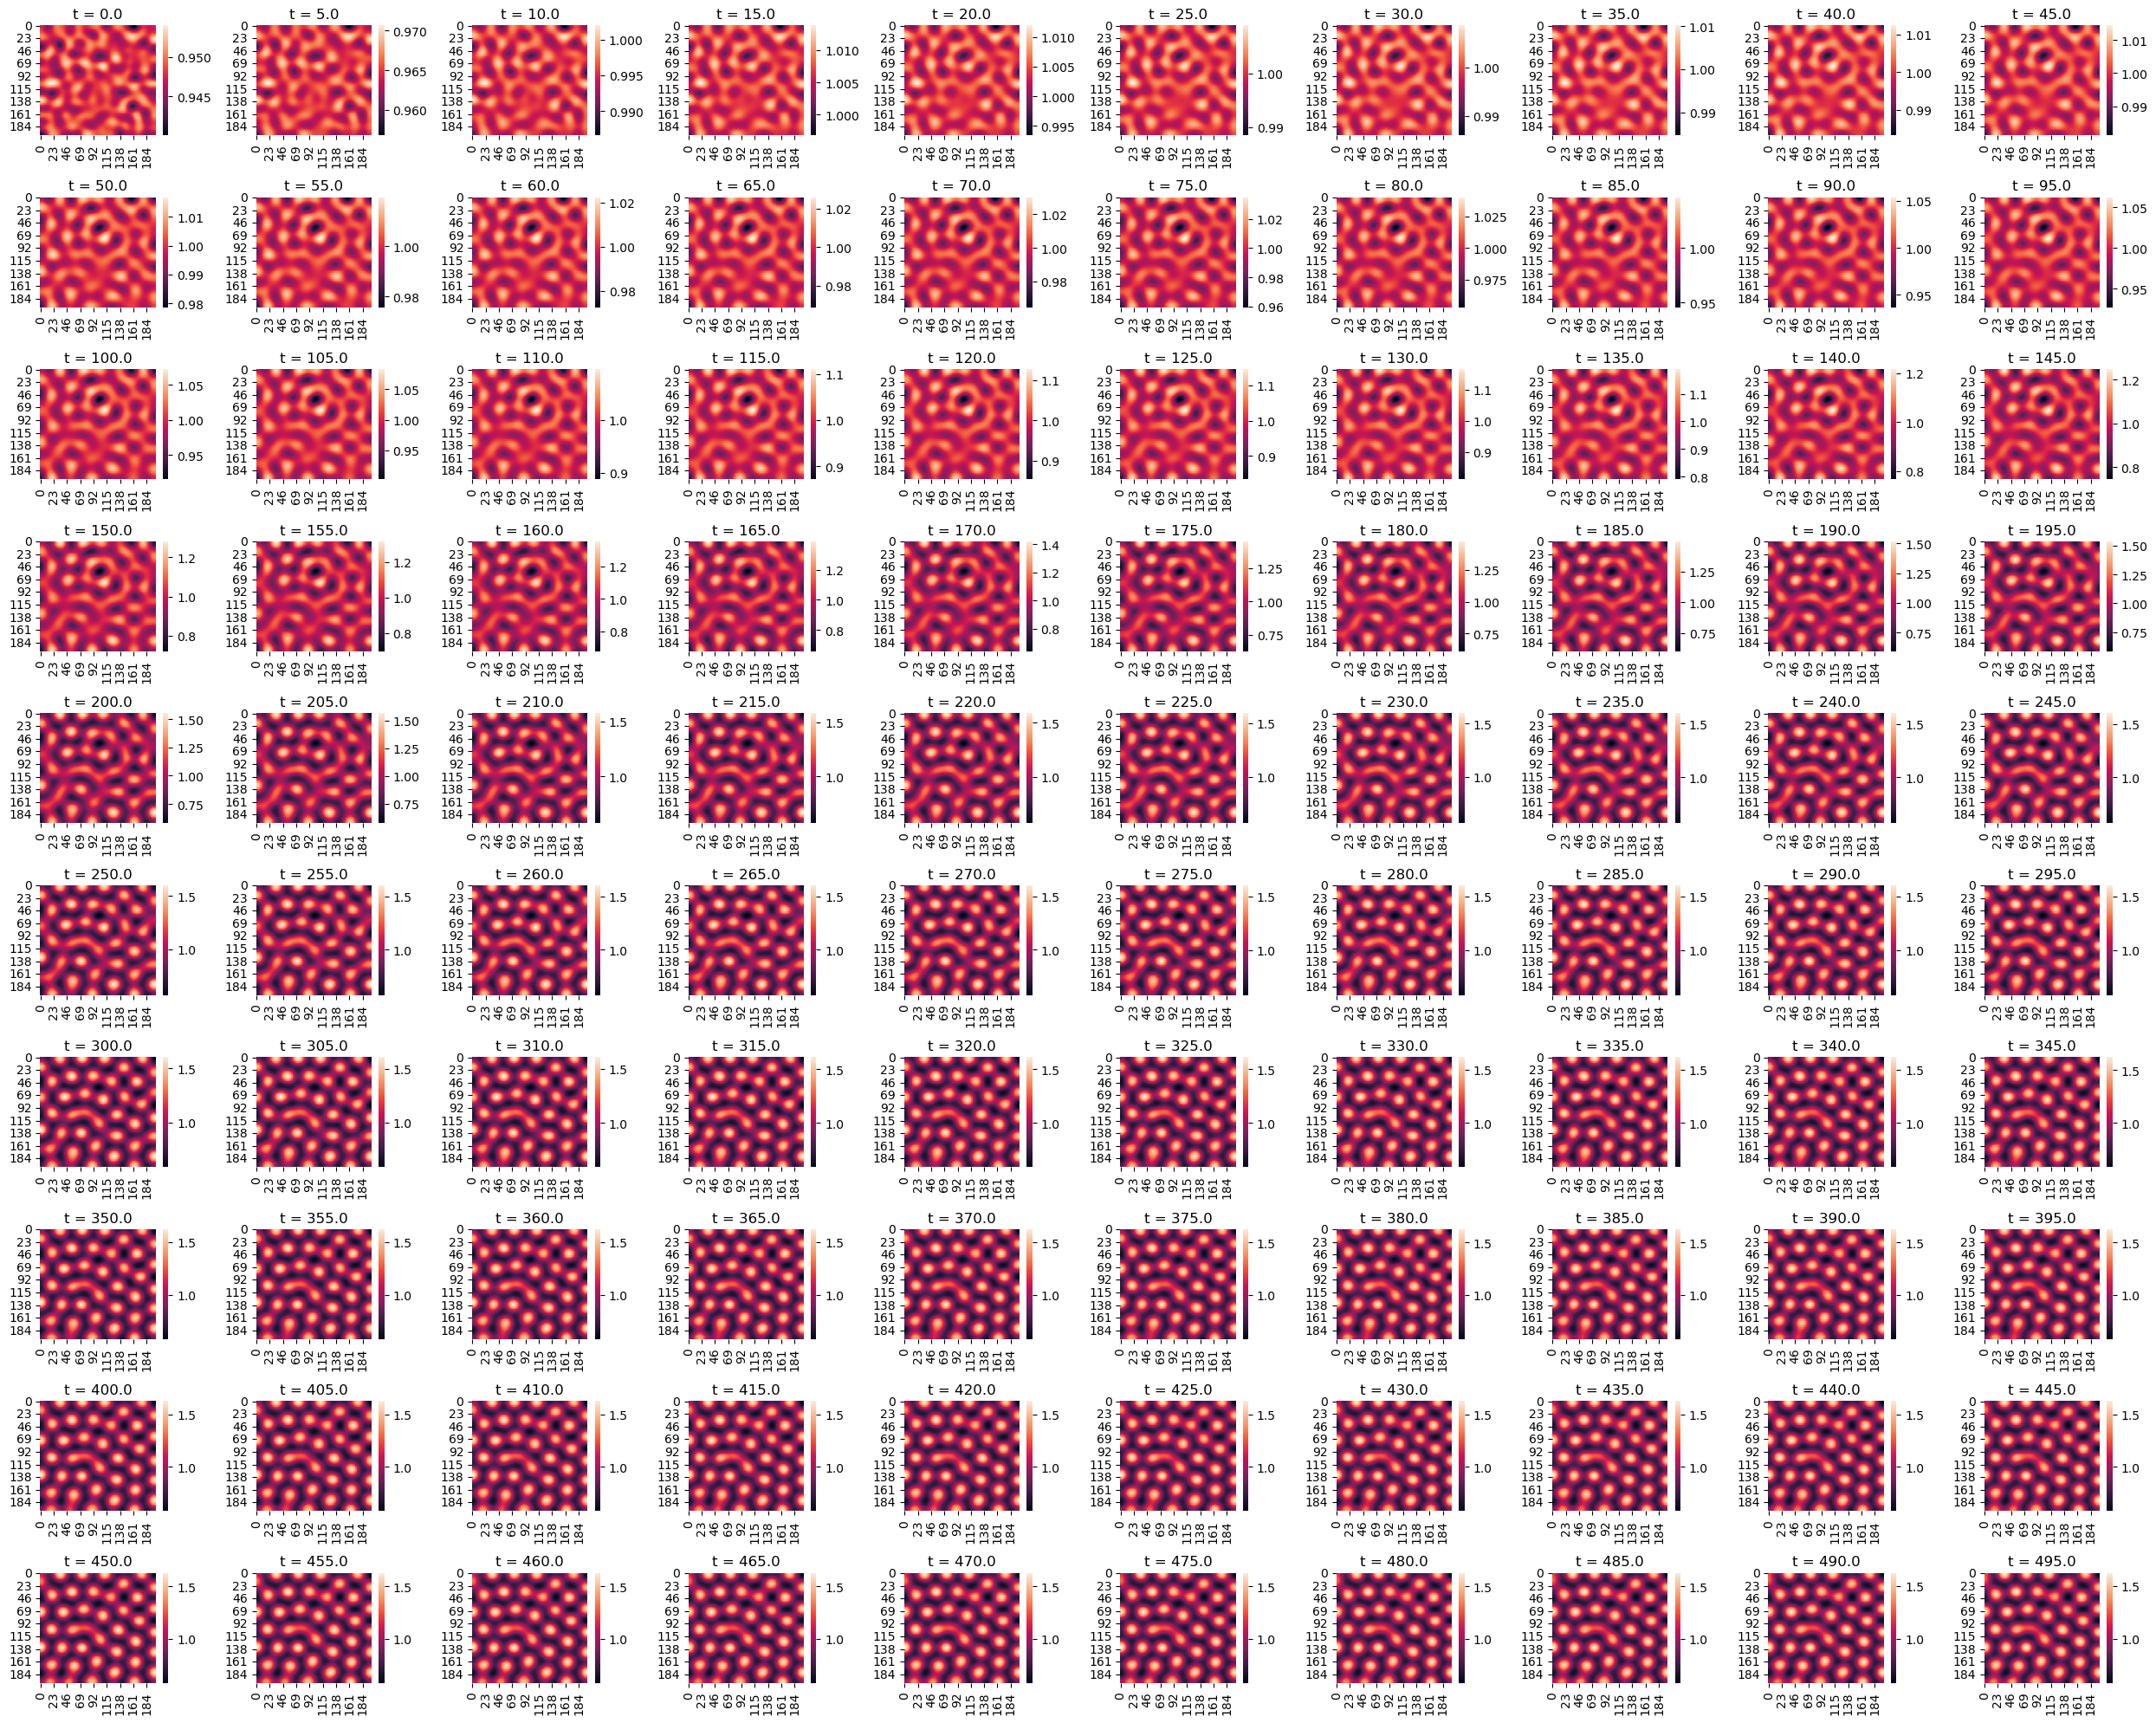

In [28]:
U = np.random.rand(size, size) * 0.1 + u_eq
V = np.random.rand(size, size) * 0.1 + v_eq
fig, axes = ax = plt.subplots(10,10, figsize=(25,20))
axes = axes.flatten()
for chunk_num in tqdm(range(100)):
    U,V = calc_n_iters(U, V, D_u, coeff_h_t, d_t, 0.1025, 1.0, 5000)
    ax = sns.heatmap(U, ax = axes[chunk_num])
    ax.set_title(f't = {chunk_num * 5000 * d_t}')
plt.tight_layout()
plt.show()
    